## Hi Dylan!
Changes:<br>
2025-07-15 - Adding looping through different `n` values, as discussed, and distribution plotting <br>
2025-07-22 - Changed randomization process, draws from entire dataframe, uses groupby and apply. Faster!

In [1]:
# imports
import pandas as pd
import numpy as np
import random
from copy import deepcopy
from itertools import starmap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from scipy import signal
from functools import partial

# # for later ...
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.stats.multitest import fdrcorrection as fdr

# This code below doesn't do anything important, 
# I just think it makes plots look nicer
from matplotlib.font_manager import findfont, FontProperties
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.serif"] = ['Georgia', 'Times New Roman',
                               'Times', 'Cambria']
font = findfont(FontProperties(family=['serif']))
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Georgia'
mpl.rcParams['mathtext.it'] = 'Georgia:italic'
mpl.rcParams['mathtext.bf'] = 'Georgia:bold'


## Loading in data

You'll have to tell the computer where to look for data
The address that directs the computer to a file is called a path

example path (from a Windows computer):
"C:\Users\jmile3\OneDrive - SCH\resting_state\corrected_spectra.csv"

On Windows, you can right click a file and "Copy as path" will show
up as an option. Not sure how to do that on Mac but might be worth
figuring out


In [2]:
# load data from tables
# variables of interest (e.g., PAF, INT, variables that parameterize aperiodic activity, organizing metadata, etc.)

# r"C:\Users\jmile3\OneDrive - SCH\resting_state\corrected_spectra.csv"

params_path = r"INSERT FOLDER LOCATION WITH 'params_table.csv' HERE"
resid_path = r"INSERT FOLDER LOCATION WITH 'corrected_spectra.csv' HERE"

params_path = r"C:\Users\jmile3\OneDrive - SCH\resting_state\params_table.csv"
resid_path = r"C:\Users\jmile3\OneDrive - SCH\resting_state\corrected_spectra.csv"

params_table = pd.read_csv(params_path,dtype={"age":float})
# power spectra - only needed in this case for confirming which data are well fit and filtering out bad fits
resid_table = pd.read_csv(resid_path,index_col=False,dtype={"ID":str,"age":float})

# initialize a random number generator for use later
rng = np.random.default_rng()

# increase number below to see more values in the table
display(params_table.head(5))

,ID,age,region,time,ix,PAF,INT,offset,slope
0,86b2be,3.42,Middle_frontal_gyrus,0.50,0,3.5,66.228450,-0.758031,1.676881
1,86b2be,3.42,Middle_frontal_gyrus,0.75,1,3.5,43.413084,-0.718833,1.851069
2,86b2be,3.42,Middle_frontal_gyrus,1.00,2,3.5,35.571238,-0.783387,1.922896
3,86b2be,3.42,Middle_frontal_gyrus,1.25,3,NaN,27.052414,-0.835454,2.111515
4,86b2be,3.42,Middle_frontal_gyrus,1.50,4,NaN,24.212618,-0.879539,2.211396


## Doing some filtering
The code below filters data so that it is a bit nicer to work with from a statistics/math standpoint. Primarily, this means:
1. getting rid of data that weren't fit well
2. applying a Gaussian-weighted average to the different timeseries of data (which are the columns of the matrix in the way the table is set up here)
3. adding an annotation for where in the hierarchy the data sit (S (sensory) or A (association)) 

In [3]:
# get rid of poor model fits
params_table["keep"] = np.squeeze(np.abs(resid_table.loc[:,['0.5']])<0.2)
params_table.loc[np.logical_not(params_table.keep),['PAF','INT']] = np.nan

# making a copy of the original data for modification
df = params_table.copy(deep=True)

# smooth with a small-window Gaussian weighted average
# window is centered, so an odd number makes most sense
win = 5
std = 1 # dictates window width i.e., influence of surrounding points
# group data by these variables - unique combinations will form unique groupings
grpvars = ["ID","age","region"]
df = df.groupby(by=grpvars,sort=False).rolling(window=win,center=True, win_type="gaussian", min_periods=1).mean(win,std).reset_index()
# this just gets rid of an extra indexing/organizing column
# should always work (so try/except probably not necessary)
try:
    df = df.drop(columns="level_3")
except:
    pass
# window fuction gets applied to all columns, but don't want these to change
# replace with the original data
df[["keep","time","ix"]] = params_table[["keep","time","ix"]]


# sensorimotor and unimodal cortex vs multi/transmodal association cortex
unimod = ["Postcentral_gyrus","Precentral_gyrus","Superior_temporal_gyrus"] # sensorimotor/unimodal regions
transmod = ["Middle_frontal_gyrus", "Middle_temporal_gyrus", "Supramarginal_gyrus"] # association/transmodal regions
df.loc[df.region.isin(unimod),'ctx'] = "S" # apparently switching to S-A axis notation...
df.loc[df.region.isin(transmod),'ctx'] = "A"

regions = df.region.unique()
print("Regions in dataset:")
for reg in regions:
    print("    ",reg)

Regions in dataset:
     Middle_frontal_gyrus
     Precentral_gyrus
     Postcentral_gyrus
     Supramarginal_gyrus
     Superior_temporal_gyrus
     Middle_temporal_gyrus


## Defining some helper functions
Functions are useful for doing operations that you expect will need to be done over and over again.

In [4]:
# functions

def n_unique(seq):
    # nunique method will exist with rolling in pandas 3.0
    return(len(seq[seq.notna()].unique()))

def genvalidseqs(in_df,col_str,n,n_valid,min_diff,min_uni):
    '''
    find all valid n-length sequences/ranges for a given df and column
    
    valid sequences/ranges are defined by:
        1) having at least n_valid non-nan elements in an n-length window
        2) having a range of at least min_diff (window max-min >= min_diff)
        3) having at least min_uni unique elements in the window

    returns a lists of valid end indices that meet the above criteria
    
    '''
    seq_series = in_df[col_str]

    # calculate the rolling sum of values that are not nan
    countnas = seq_series.notna().rolling(window=n,center=False,min_periods=n_valid).sum()
    # create a boolean array of values that are above a threshold
    valid_counts = countnas>=n_valid
    
    # calculate the range of values in the window
    maxs = seq_series.rolling(window=n,center=False,min_periods=1).max(skipna=True)
    # pandas is telling me it can't use skipna for min? maybe if I update to 2.3...
    mins = seq_series.rolling(window=n,center=False,min_periods=1).min(numeric_only=True)
    # create a boolean array of values that are above a threshold
    valid_ranges = (maxs-mins)>=min_diff
    
    # calculate the range of values in the window
    num_diffs = seq_series.rolling(window=n,center=False,min_periods=1).apply(n_unique)
    # create a boolean array of values that are above a threshold
    valid_unis = num_diffs>=min_uni
    # union of boolean masks as array of indices
    valid_ends = in_df.index[valid_counts & valid_ranges & valid_unis].to_numpy() 
    # valid_ends will be used as ending value in range, need to add 1?
    # prevent negative values
    return valid_ends[valid_ends>=n]



Your goal is to set the values below:
```
n
min_diff
min_uni
```

`n` is the number of consecutive indices needed in a sequence for calculating a correlation
`min_diff` is the range that values should span to count as a valid sequence
`min_uni` is the minimum number of unique values that should occur for a sequence to be considered valid

86b2be
Middle_temporal_gyrus
418


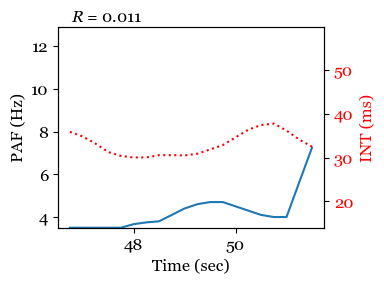

In [5]:
###################
# figure out these values !!!
n = 20
min_diff = 2
min_uni = 5
##################

# proportion of values that cannot be nan
n_valid = int(np.floor(n*2/3))

# randomly pick an ID
ID = rng.choice(df.ID.unique())
print(ID)
# filter table so you're just looking at data from
# randomly chosen ID
subdf = df.loc[df.ID == ID,:].reset_index(drop=True) 
# randomly pick a region from that ID
reg = rng.choice(subdf.region[subdf.ctx=="A"])
print(reg)
# now just get data from that ID's region
reg_df = subdf.loc[subdf.region == reg,:].reset_index(drop=True)

endixs = genvalidseqs(reg_df,"PAF",n,n_valid,min_diff,min_uni)
print(len(endixs))

all_ixs = list(starmap(np.arange,np.array((endixs-n,endixs)).T))

##########
# plotting
##########

# randomly grab one of the possible valid indices
plot_ixs = np.array(all_ixs[rng.integers(0,high=len(all_ixs))])

# generate a figure
fig,ax = plt.subplots(figsize=(4,3),tight_layout=True)
    
ax.plot(reg_df.time[plot_ixs],reg_df.PAF[plot_ixs])
ax.set_ylim([np.percentile(df.PAF[df.PAF.notna()],0.5), 
             np.percentile(df.PAF[df.PAF.notna()],99.5)])
ax.set_ylabel("PAF (Hz)")
ax.set_xlabel("Time (sec)")
ax2 = ax.twinx()
ax2.plot(reg_df.time[plot_ixs],reg_df.INT[plot_ixs],"r:")
ax2.set_ylim([np.percentile(df.INT[df.INT.notna()],0.5), 
              np.percentile(df.INT[df.INT.notna()],99.5)])
ax2.set_ylabel("INT (ms)",color="red")
ax2.set_xlabel("Time (sec)")
ax2.tick_params(axis='y', labelcolor='red')

# NOTE:
# y limits are set based on 1st and 99th percentiles
# these can be changed to zoom in 
# (can't zoom out much, set to contain 99% of data)
# can also set them manually (PAF can be between 3 and 14, INT around 10 to 100)

# OTHER NOTE:
# might see gaps in data - these are periods when there are no valid data
# this almost always means no alpha oscillation was detectable

# have to mask out nans to do correlations, this excludes across df index (row)
nanmask = reg_df.loc[plot_ixs,["PAF","INT"]].notna().all(axis=1)
corr = np.round(stats.pearsonr(reg_df.INT[plot_ixs[nanmask]],reg_df.PAF[plot_ixs[nanmask]]).statistic,3)

ax2.annotate("$R$ = "+str(corr),xy=(0.05, 1.025), xycoords="axes fraction")

plt.show()

## Looping through different durations of data

For simplicity, the cell below is the same as the one above, but with the important part inclosed in a `for loop`. <br>
The value of `n` changes each loop *iteration*, and calculates correlations for `iters` random selections of data. <br>


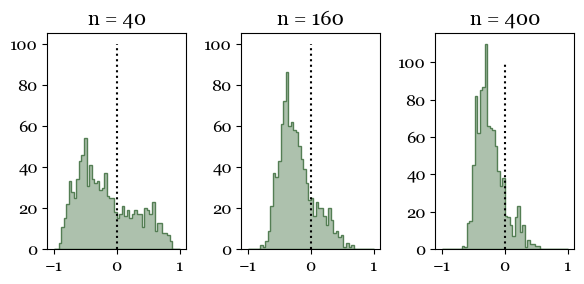

CPU times: total: 2min 42s
Wall time: 2min 42s


In [6]:
%%time

min_diff = 2
min_uni = 5
# looping over this list of values for n
n_list = [40, 160, 400]
iters = 1000 

# generate a figure
fig,ax = plt.subplots(nrows=1,ncols=len(n_list),figsize=(6,3),tight_layout=True)
# keep track of plotting locations
row = 0
col = 0
for n in n_list:
    # create a container to store values in
    n_corrs = [] # empty list
    # proportion of values that cannot be nan
    if n <= 40:
        n_valid = int(np.floor(n*2/3))
    elif n > 40:
        n_valid = int(np.floor(n/2))

    # Partial function to add multiple args
    # don't supply the first arg (df_in) b/c that will be the df
    # have to do each iteration b/c n changes
    ##### key diff ######
    partial_func = partial(genvalidseqs,col_str="PAF",n=n,n_valid=n_valid,min_diff=min_diff,min_uni=min_uni)
    all_ends = df.loc[df.ID!='71944e',:].groupby(by=["ID","region"]).apply(partial_func, include_groups=False)
    #####################
    
    # randomly pick an ID and corresponding reg
    # multi-index tuples for use in groupby object
    randixs = rng.choice(all_ends.index,[iters,1])
    corrs = []
    
    for tup in randixs:
        endixs = np.squeeze(all_ends[tup])
        # randomly pick one of the valid sequences
        randix = rng.choice(endixs)
        plot_ixs = np.arange(randix-n,randix)+1
        # mask out nans
        nanmask = df.loc[plot_ixs,["PAF","INT"]].notna().all(axis=1)
        # calculate correlation
        corrs.append(stats.pearsonr(df.INT[plot_ixs[nanmask]],df.PAF[plot_ixs[nanmask]]).statistic)

    ax[col].hist(corrs,bins=np.linspace(-1,1,51),histtype='stepfilled',ec=[0.2,0.4,0.2,0.8],fc=[0.2,0.4,0.2,0.4])
    ax[col].plot([0,0],[0,iters/10],"k:")
    ax[col].set_title("n = "+str(n))
    col = col+1
# show the plots (at the end - out of the loop)
plt.show()

## can probably get rid of code below...

In [49]:
# storing all of the valid endixs for each ID-reg combo
# avoids recomputing on-the-fly, just draw from pre-computed
# have to do this for each n...

def genvalid_dict(in_df,col_str,n,n_valid,min_diff,min_uni):
    '''
    storing all of the valid endixs for each ID-reg combo
    avoids recomputing on-the-fly, just draw from pre-computed
    have to do for each n

    returns a dict of dicts:
        "outer" keys = ID (str)
        "outer" values = reg_dict (dict)
        "inner" keys = reg (str)
        "inner" values = validixs (list)
    '''
    all_valids = {}
    for ID in in_df.ID.unique():
        subdf = in_df.loc[in_df.ID==ID]
        # all endixs per region will go in here (dictionary)
        # dict keys = reg, values = list of endixs
        reg_dict = {}
        for reg in subdf.region.unique():
            reg_df = subdf.loc[subdf.region == reg,:].reset_index(drop=True)
            # generate the valid sequences for reg_df
            reg_dict[reg] = genvalidseqs(reg_df,"PAF",n,n_valid,min_diff,min_uni)
        # add the reg_dict to the all_valids
        all_valids[ID] = reg_dict
    return all_valids



50
100
200
400


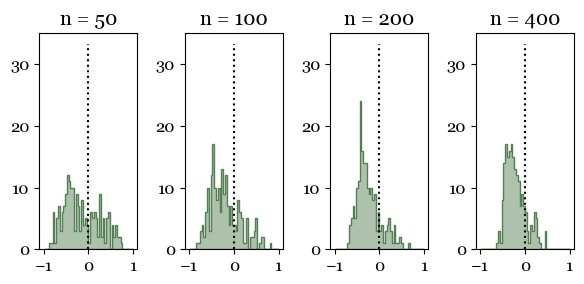

CPU times: total: 3min 27s
Wall time: 3min 28s


In [180]:
%%time
###################
# figure out these values !!!
n = 20 # this will soon change based on list below
min_diff = 2
min_uni = 5
##################

#### new variables #####
# looping over this list of values for n
n_list = [50, 100, 200, 400]
# 100 is pretty small, but code is too slow for more right now
iters = 200 

# generate a figure
fig,ax = plt.subplots(nrows=1,ncols=len(n_list),figsize=(6,3),tight_layout=True)
# keep track of plotting locations
row = 0
col = 0
for n in n_list:
    # create a container to store values in
    n_corrs = [] # empty list
    # proportion of values that cannot be nan
    if n <= 40:
        n_valid = int(np.floor(n*2/3))
    elif n > 40:
        n_valid = int(np.floor(n/2))

    all_valid = genvalid_dict(df.loc[df.ID!="71944e"],"PAF",n,n_valid,min_diff,min_uni)
    print(n)
    for it in range(iters):
        # randomly pick an ID and corresponding reg
        ID = rng.choice(list(all_valid.keys()))
        reg = rng.choice(list(all_valid[ID].keys()))
        # if I don't reset_indices in genvalid_dict, don't 
        # need to create the reg_df, do I?
        reg_df = df.loc[(df.ID==ID)&(df.region==reg),:].reset_index(drop=True)
        # generate the valid sequences for reg_df
        randix = rng.choice(all_valid[ID][reg])
        plot_ixs = np.arange(randix-n,randix)+1 # is it right to add 1?
        # mask out nans
        nanmask = reg_df.loc[plot_ixs,["PAF","INT"]].notna().all(axis=1)
        # "append" (add) correlation to the container we made
        n_corrs.append(stats.pearsonr(reg_df.INT[plot_ixs[nanmask]],reg_df.PAF[plot_ixs[nanmask]]).statistic)
        # end of the inner loop is here

    ##########
    # plotting
    ##########

    ax[col].hist(n_corrs,bins=np.linspace(-1,1,51),histtype='stepfilled',ec=[0.2,0.4,0.2,0.8],fc=[0.2,0.4,0.2,0.4])
    ax[col].plot([0,0],[0,iters/6],"k:")
    ax[col].set_title("n = "+str(n))
    # "increment" counter for columns (only 1 row for now)
    col = col+1
# show the plots (at the end - out of the loop)
plt.show()

10
20
40
80
160


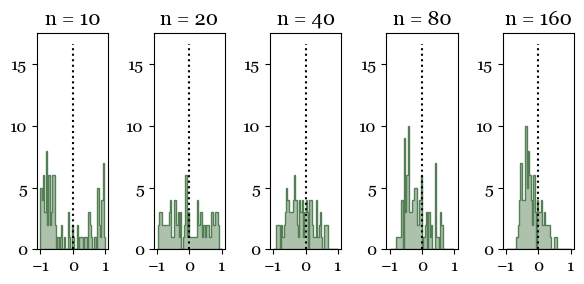

CPU times: total: 6min 43s
Wall time: 6min 44s


In [64]:
%%time
# old (7/15)
###################
# figure out these values !!!
n = 20 # this will soon change based on list below
min_diff = 2
min_uni = 5
##################

#### new variables #####
# looping over this list of values for n
n_list = [10, 20, 40, 80, 160]
# 100 is pretty small, but code is too slow for more right now
iters = 100 

# generate a figure
fig,ax = plt.subplots(nrows=1,ncols=len(n_list),figsize=(6,3),tight_layout=True)
# keep track of plotting locations
row = 0
col = 0
for n in n_list:
    # create a container to store values in
    n_corrs = [] # empty list
    # proportion of values that cannot be nan
    n_valid = int(np.floor(n*2/3))
    print(n)
    for it in range(iters):
        # randomly pick an ID
        ID = rng.choice(df.ID.unique()[df.ID.unique()!="71944e"])
        # filter table so you're just looking at data from
        # randomly chosen ID
        subdf = df.loc[df.ID == ID,:].reset_index(drop=True) 
        # randomly pick a region from that ID
        reg = rng.choice(subdf.region.unique())
        # now just get data from that ID's region
        reg_df = subdf.loc[subdf.region == reg,:].reset_index(drop=True)
        # generate the valid sequences for reg_df
        endixs = genvalidseqs(reg_df,"PAF",n,n_valid,min_diff,min_uni)        
        all_ixs = list(starmap(np.arange,np.array((endixs-n,endixs)).T))
        # randomly pick one of the valid sequences
        plot_ixs = np.array(all_ixs[rng.integers(0,high=len(all_ixs))])
        # mask out nans
        nanmask = reg_df.loc[plot_ixs,["PAF","INT"]].notna().all(axis=1)
        # calculate correlation
        corr = stats.pearsonr(reg_df.INT[plot_ixs[nanmask]],reg_df.PAF[plot_ixs[nanmask]]).statistic
        # "append" (add) corr to the container we made
        n_corrs.append(corr)
        # end of the inner loop is here

    ##########
    # plotting
    ##########

    ax[col].hist(n_corrs,bins=np.linspace(-1,1,51),histtype='stepfilled',ec=[0.2,0.4,0.2,0.8],fc=[0.2,0.4,0.2,0.4])
    ax[col].plot([0,0],[0,iters/6],"k:")
    ax[col].set_title("n = "+str(n))
    # "increment" counter for columns (only 1 row for now)
    col = col+1
# show the plots (at the end - out of the loop)
plt.show()